# 🏏 CricOracle 2026 — Exploratory Data Analysis
---
**Objective:** Understand our T20I ball-by-ball dataset before building features.

This notebook uses the production `CricketDataLoader` — the same code that feeds the ML pipeline.
We're answering 5 key questions:
1. **Scale** — How much data do we have?
2. **Quality** — Any missing values, anomalies, or data issues?
3. **Distributions** — How do runs, wickets, and scores behave?
4. **Venue & Team patterns** — Which venues/teams dominate?
5. **Temporal trends** — Has T20 cricket changed over time?

In [2]:
# Cell 1: Imports and setup
import sys
sys.path.insert(0, "../../..")  # So we can import src/ from notebooks/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Use our production data loader
from src.data.loader import CricketDataLoader

# Plot settings
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 30)
pd.set_option("display.float_format", "{:.2f}".format)

print("Imports OK ✓")

Imports OK ✓


## 1. Load Data Through Production Pipeline
This is the exact same loader that feeds the ML models.
It handles: column standardisation → derive missing cols → date parsing → validation → memory optimisation.

In [3]:
# Cell 2: Load data
loader = CricketDataLoader()
df = loader.load_and_clean(modern_era_only=True)

print(f"Shape: {df.shape}")
print(f"Matches: {df['match_id'].nunique():,}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nColumns ({len(df.columns)}):")
print(list(df.columns))

2026-02-16 22:27:06 | INFO     | src.data.loader:load_and_clean:37 | Loading data from C:\Users\amant\PycharmProjects\CricOracle2026\data\raw\t20_ball_by_ball_v2.csv
2026-02-16 22:27:08 | INFO     | src.data.loader:_load_raw:71 | Raw data: 706,342 rows, 16 columns
2026-02-16 22:27:08 | INFO     | src.data.loader:_standardise_columns:82 | Standardised columns: {'runs_extra': 'runs_extras', 'player_out': 'player_dismissed'}
2026-02-16 22:27:08 | INFO     | src.data.loader:_derive_columns:108 | Derived 'bowling_team' from team1/team2/batting_team
2026-02-16 22:27:08 | INFO     | src.data.loader:_derive_columns:125 | Derived 'inning_no' from batting order within each match
2026-02-16 22:27:09 | INFO     | src.data.loader:_derive_columns:132 | Derived 'ball_no' from within-over sequence
2026-02-16 22:27:09 | INFO     | src.data.loader:_derive_columns:138 | Derived 'is_wicket': 40,228 wickets found
2026-02-16 22:27:09 | INFO     | src.data.loader:_create_helper_columns:166 | Created helper c

Shape: (565377, 24)
Matches: 2,519
Date range: 2019-01-11 → 2026-02-03
Memory: 62.5 MB

Columns (24):
['match_id', 'date', 'venue', 'team1', 'team2', 'winner', 'batting_team', 'over', 'batter', 'bowler', 'non_striker', 'runs_batter', 'runs_extras', 'runs_total', 'wicket_type', 'player_dismissed', 'bowling_team', 'inning_no', 'ball_no', 'is_wicket', 'is_four', 'is_six', 'is_dot', 'phase']


In [4]:
# Cell 3: First 10 rows — check the data looks right
df.head(10)

,match_id,date,venue,team1,team2,winner,batting_team,over,batter,bowler,non_striker,runs_batter,runs_extras,runs_total,wicket_type,player_dismissed,bowling_team,inning_no,ball_no,is_wicket,is_four,is_six,is_dot,phase
0,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Sahibzada Farhan,XC Bartlett,Saim Ayub,0,0,0,caught and bowled,Sahibzada Farhan,Australia,1,1,1,0,0,1,Powerplay
1,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Agha Salman,XC Bartlett,Saim Ayub,1,0,1,NaN,NaN,Australia,1,2,0,0,0,0,Powerplay
2,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Saim Ayub,XC Bartlett,Agha Salman,6,0,6,NaN,NaN,Australia,1,3,0,0,1,0,Powerplay
3,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Saim Ayub,XC Bartlett,Agha Salman,0,0,0,NaN,NaN,Australia,1,4,0,0,0,1,Powerplay
4,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Saim Ayub,XC Bartlett,Agha Salman,1,0,1,NaN,NaN,Australia,1,5,0,0,0,0,Powerplay
5,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,0,Agha Salman,XC Bartlett,Saim Ayub,0,0,0,NaN,NaN,Australia,1,6,0,0,0,1,Powerplay
6,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,1,Saim Ayub,C Connolly,Agha Salman,1,0,1,NaN,NaN,Australia,1,1,0,0,0,0,Powerplay
7,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,1,Agha Salman,C Connolly,Saim Ayub,0,0,0,NaN,NaN,Australia,1,2,0,0,0,1,Powerplay
8,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,1,Agha Salman,C Connolly,Saim Ayub,0,0,0,NaN,NaN,Australia,1,3,0,0,0,1,Powerplay
9,1519636,2026-01-29,"Gaddafi Stadium, Lahore",Pakistan,Australia,Pakistan,Pakistan,1,Agha Salman,C Connolly,Saim Ayub,6,0,6,NaN,NaN,Australia,1,4,0,0,1,0,Powerplay


In [5]:
# Cell 4: Data types and null counts
print("=== Data Types ===")
print(df.dtypes)
print(f"\n=== Null Counts ===")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.any() else "No nulls ✓")

=== Data Types ===
match_id                     int64
date                datetime64[us]
venue                     category
team1                     category
team2                     category
winner                    category
batting_team              category
over                          int8
batter                    category
bowler                    category
non_striker               category
runs_batter                   int8
runs_extras                   int8
runs_total                    int8
wicket_type                    str
player_dismissed               str
bowling_team              category
inning_no                     int8
ball_no                       int8
is_wicket                     int8
is_four                       int8
is_six                        int8
is_dot                        int8
phase                     category
dtype: object

=== Null Counts ===
wicket_type         532861
player_dismissed    532861
dtype: int64


## 2. Match-Level Summary
Before diving into ball-level data, let's understand the match landscape.

In [6]:
# Cell 5: Match-level summary
matches = loader.get_match_list(df)
print(f"Total matches: {len(matches)}")
print(f"\nMatches per year:")
matches["year"] = pd.to_datetime(matches["date"]).dt.year
print(matches["year"].value_counts().sort_index())

2026-02-16 22:28:51 | INFO     | src.data.loader:get_match_list:239 | Match list: 2519 matches


Total matches: 2519

Matches per year:
year
2019    206
2020     72
2021    289
2022    444
2023    345
2024    611
2025    531
2026     21
Name: count, dtype: int64


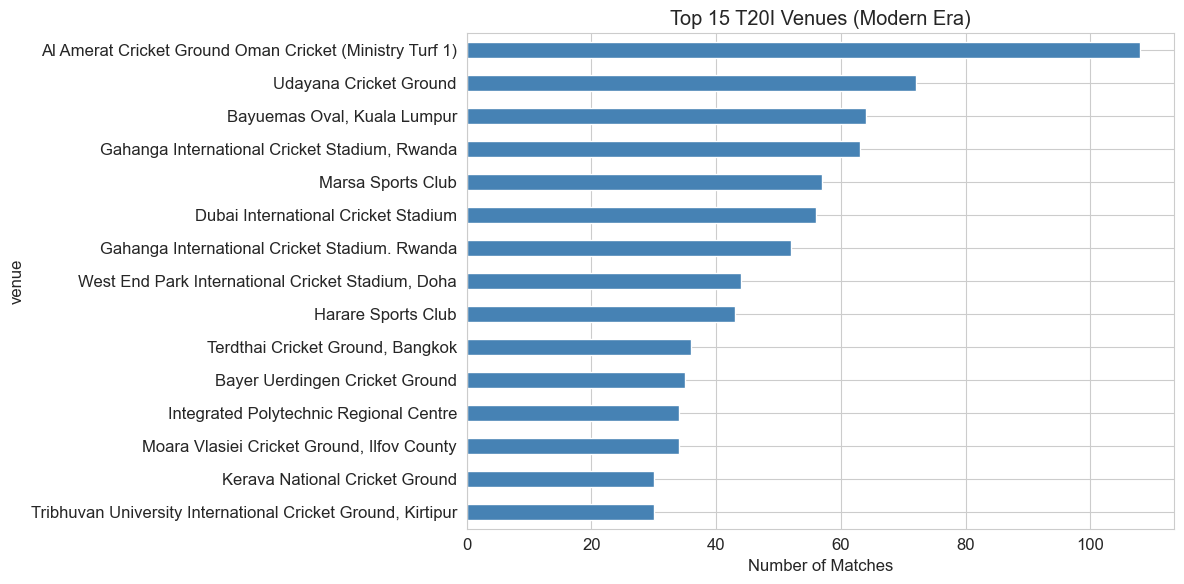

In [7]:
# Cell 6: Top venues by match count
venue_counts = matches["venue"].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 6))
venue_counts.plot(kind="barh", ax=ax, color="steelblue")
ax.set_xlabel("Number of Matches")
ax.set_title("Top 15 T20I Venues (Modern Era)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

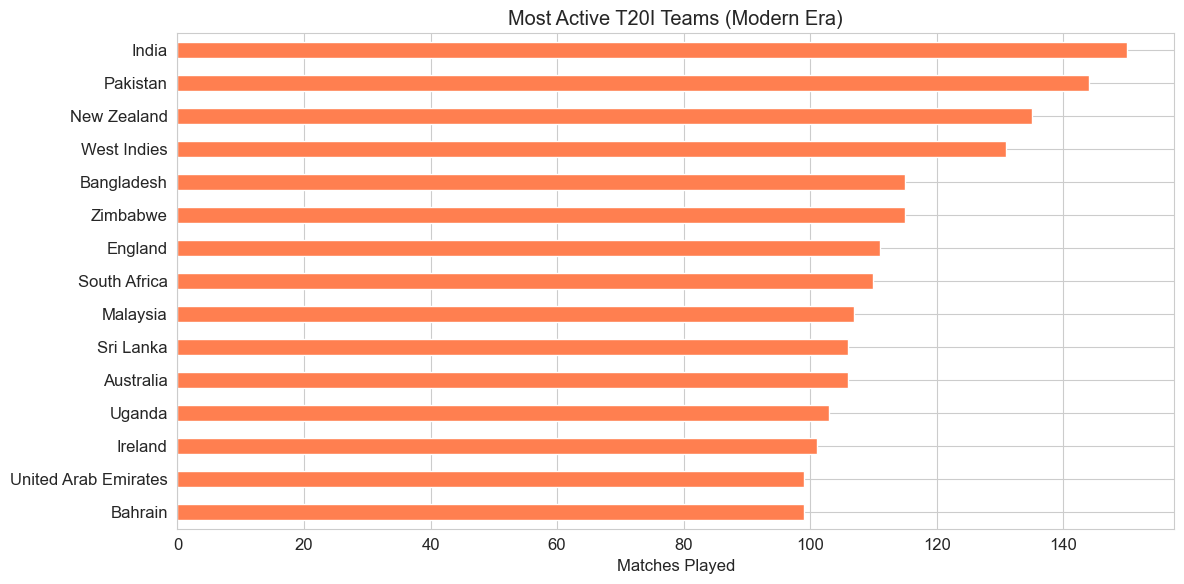

In [8]:
# Cell 7: Top teams by match count
team_counts = pd.concat([matches["team1"], matches["team2"]]).value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 6))
team_counts.plot(kind="barh", ax=ax, color="coral")
ax.set_xlabel("Matches Played")
ax.set_title("Most Active T20I Teams (Modern Era)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Scoring Patterns
The heart of T20 analytics — how runs flow across matches.

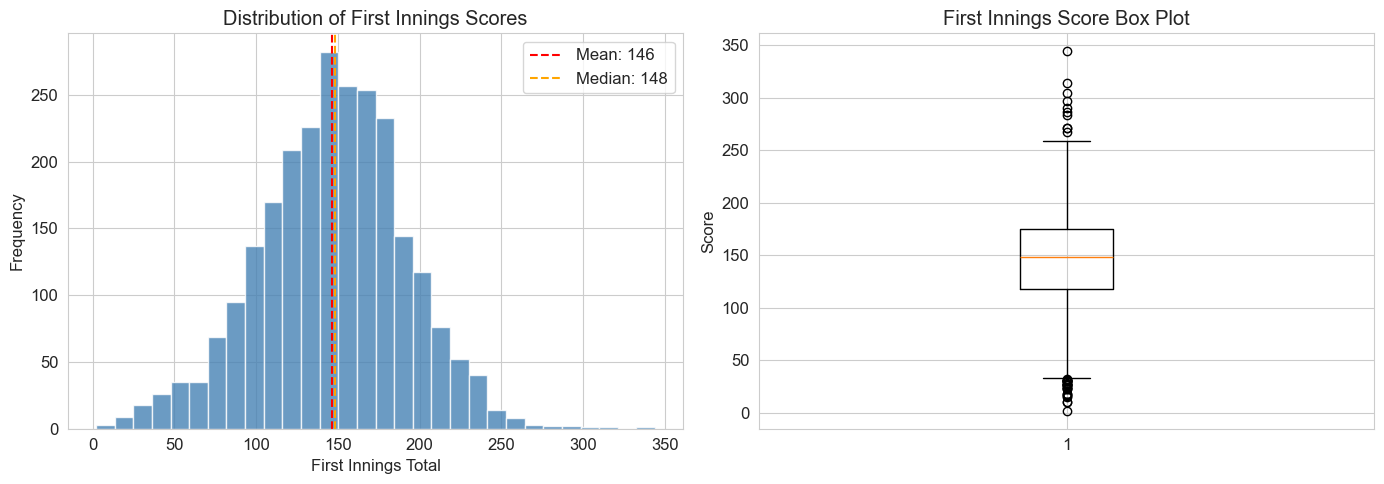

First Innings Stats:
count   2519.00
mean     146.30
std       44.80
min        2.00
25%      118.00
50%      148.00
75%      175.00
max      344.00
Name: total_score, dtype: float64


In [9]:
# Cell 8: First innings totals distribution
innings1 = (
    df[df["inning_no"] == 1]
    .groupby("match_id")["runs_total"]
    .sum()
    .reset_index()
    .rename(columns={"runs_total": "total_score"})
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(innings1["total_score"], bins=30, color="steelblue", edgecolor="white", alpha=0.8)
axes[0].axvline(innings1["total_score"].mean(), color="red", linestyle="--", label=f"Mean: {innings1['total_score'].mean():.0f}")
axes[0].axvline(innings1["total_score"].median(), color="orange", linestyle="--", label=f"Median: {innings1['total_score'].median():.0f}")
axes[0].set_xlabel("First Innings Total")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of First Innings Scores")
axes[0].legend()

# Box plot
axes[1].boxplot(innings1["total_score"], vert=True)
axes[1].set_ylabel("Score")
axes[1].set_title("First Innings Score Box Plot")

plt.tight_layout()
plt.show()

print(f"First Innings Stats:")
print(innings1["total_score"].describe().round(1))

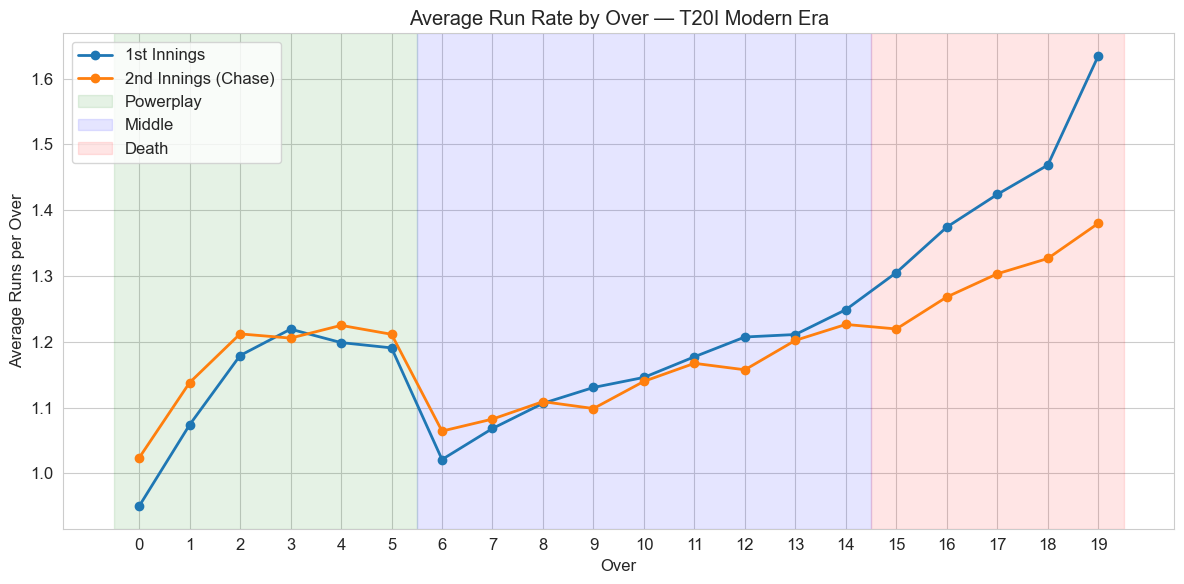

In [10]:
# Cell 9: Runs per over (the classic "worm" pattern)
over_runs = (
    df.groupby(["inning_no", "over"])["runs_total"]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))
for inn in [1, 2]:
    data = over_runs[over_runs["inning_no"] == inn]
    label = "1st Innings" if inn == 1 else "2nd Innings (Chase)"
    ax.plot(data["over"], data["runs_total"], marker="o", label=label, linewidth=2)

ax.axvspan(-0.5, 5.5, alpha=0.1, color="green", label="Powerplay")
ax.axvspan(5.5, 14.5, alpha=0.1, color="blue", label="Middle")
ax.axvspan(14.5, 19.5, alpha=0.1, color="red", label="Death")
ax.set_xlabel("Over")
ax.set_ylabel("Average Runs per Over")
ax.set_title("Average Run Rate by Over — T20I Modern Era")
ax.legend()
ax.set_xticks(range(20))
plt.tight_layout()
plt.show()

In [11]:
# Cell 10: Phase-wise scoring breakdown
phase_stats = (
    df.groupby("phase")
    .agg(
        avg_runs=("runs_total", "mean"),
        boundary_pct=("is_four", "mean"),
        six_pct=("is_six", "mean"),
        dot_pct=("is_dot", "mean"),
        wicket_pct=("is_wicket", "mean"),
    )
    .round(3)
)
phase_stats["boundary_pct"] = (phase_stats["boundary_pct"] * 100).round(1)
phase_stats["six_pct"] = (phase_stats["six_pct"] * 100).round(1)
phase_stats["dot_pct"] = (phase_stats["dot_pct"] * 100).round(1)
phase_stats["wicket_pct"] = (phase_stats["wicket_pct"] * 100).round(1)

phase_stats.columns = ["Avg Runs/Ball", "Four %", "Six %", "Dot %", "Wicket %"]
print("Phase-wise T20I Breakdown:")
print(phase_stats)

Phase-wise T20I Breakdown:
           Avg Runs/Ball  Four %  Six %  Dot %  Wicket %
phase                                                   
Powerplay           1.15   12.30   3.40  47.40      4.60
Middle              1.14    7.10   4.00  36.70      5.10
Death               1.38    9.00   6.10  32.20      9.10


## 4. Wicket Patterns
Understanding when and how wickets fall is crucial for the win predictor.

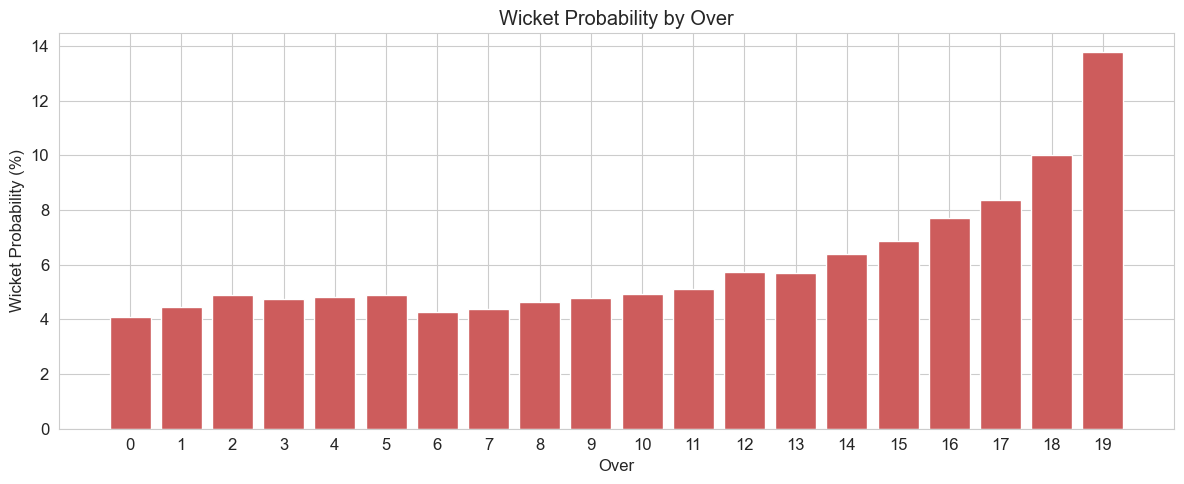

In [12]:
# Cell 11: Wickets by over
wickets_by_over = (
    df.groupby("over")["is_wicket"]
    .mean()
    .reset_index()
)
wickets_by_over["is_wicket"] *= 100

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(wickets_by_over["over"], wickets_by_over["is_wicket"], color="indianred", edgecolor="white")
ax.set_xlabel("Over")
ax.set_ylabel("Wicket Probability (%)")
ax.set_title("Wicket Probability by Over")
ax.set_xticks(range(20))
plt.tight_layout()
plt.show()

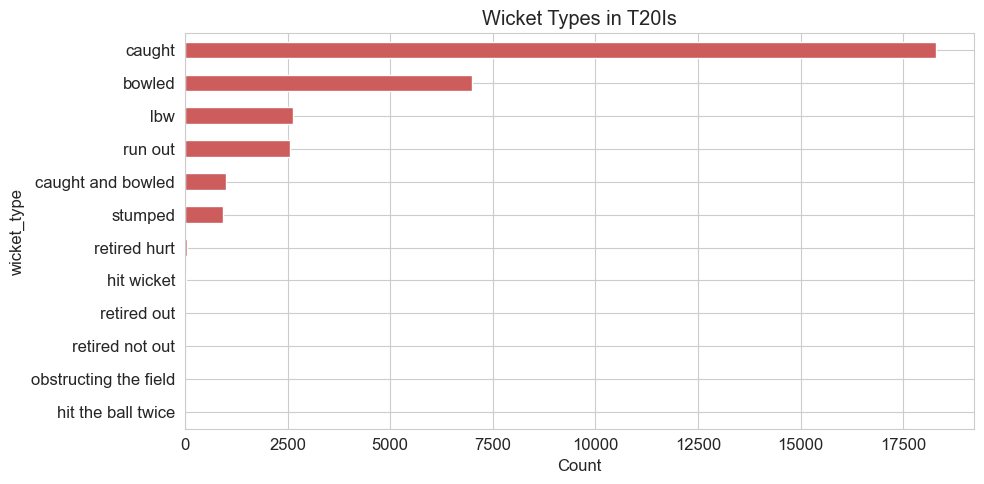

In [13]:
# Cell 12: Wicket types distribution
if "wicket_type" in df.columns:
    wkt_types = df[df["is_wicket"] == 1]["wicket_type"].value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    wkt_types.plot(kind="barh", ax=ax, color="indianred")
    ax.set_xlabel("Count")
    ax.set_title("Wicket Types in T20Is")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("wicket_type column not available after processing")

## 5. Toss & Chase Analysis
The toss is a major feature in our model. Does batting first vs chasing matter?

In [20]:
# Cell 13: Win rates — batting first vs chasing
match_results = (
    df.groupby("match_id")
    .agg(
        team_batting_first=("batting_team", "first"),
        winner=("winner", "first"),
    )
    .reset_index()
)

# .astype(str) fixes the categorical comparison error
match_results["bat_first_won"] = (
    match_results["team_batting_first"].astype(str) == match_results["winner"].astype(str)
).astype(int)

# Remove no results / ties
match_results = match_results.dropna(subset=["winner"])
bat_first_win_rate = match_results["bat_first_won"].mean() * 100

print(f"Batting First Win Rate: {bat_first_win_rate:.1f}%")
print(f"Chasing Win Rate: {100 - bat_first_win_rate:.1f}%")
print(f"\n(Based on {len(match_results)} matches)")

Batting First Win Rate: 46.8%
Chasing Win Rate: 53.2%

(Based on 2519 matches)


## 6. Top Performers
Quick look at the most prolific batters and bowlers in the dataset.

In [ ]:
# Cell 14: Top 15 run scorers
top_batters = (
    df.groupby("batter")
    .agg(
        runs=("runs_batter", "sum"),
        balls=("runs_batter", "count"),
        fours=("is_four", "sum"),
        sixes=("is_six", "sum"),
        matches=("match_id", "nunique"),
    )
    .query("balls >= 100")
    .assign(strike_rate=lambda x: (x["runs"] / x["balls"] * 100).round(1))
    .sort_values("runs", ascending=False)
    .head(15)
)

print("Top 15 Run Scorers (min 100 balls faced):")
print(top_batters.to_string())

In [16]:
# Cell 15: Top 15 wicket takers
top_bowlers = (
    df.groupby("bowler")
    .agg(
        wickets=("is_wicket", "sum"),
        balls=("is_wicket", "count"),
        runs_conceded=("runs_total", "sum"),
        matches=("match_id", "nunique"),
    )
    .query("balls >= 60")
    .assign(
        economy=lambda x: (x["runs_conceded"] / (x["balls"] / 6)).round(2),
        strike_rate=lambda x: (x["balls"] / x["wickets"].replace(0, np.nan)).round(1),
    )
    .sort_values("wickets", ascending=False)
    .head(15)
)

print("Top 15 Wicket Takers (min 60 balls bowled):")
print(top_bowlers.to_string())

Top 15 Wicket Takers (min 60 balls bowled):
                     wickets  balls  runs_conceded  matches  economy  strike_rate
bowler                                                                           
PWH de Silva             145   1942           2349       85     7.26        13.40
Haris Rauf               138   1983           2734       88     8.27        14.40
MR Adair                 137   2039           2515       88     7.40        14.90
Ehsan Khan               135   1984           2095       88     6.34        14.70
Rizwan Butt              130   1746           1935       78     6.65        13.40
S Lamichhane             128   1495           1502       63     6.03        11.70
IS Sodhi                 127   2167           2950      102     8.17        17.10
AU Rashid                123   2211           2737       98     7.43        18.00
Arshdeep Singh           119   1583           2180       70     8.26        13.30
Shaheen Shah Afridi      118   1964           2522    

## 7. Year-over-Year Trends
T20 cricket has evolved — scoring rates have increased, strategies have changed.

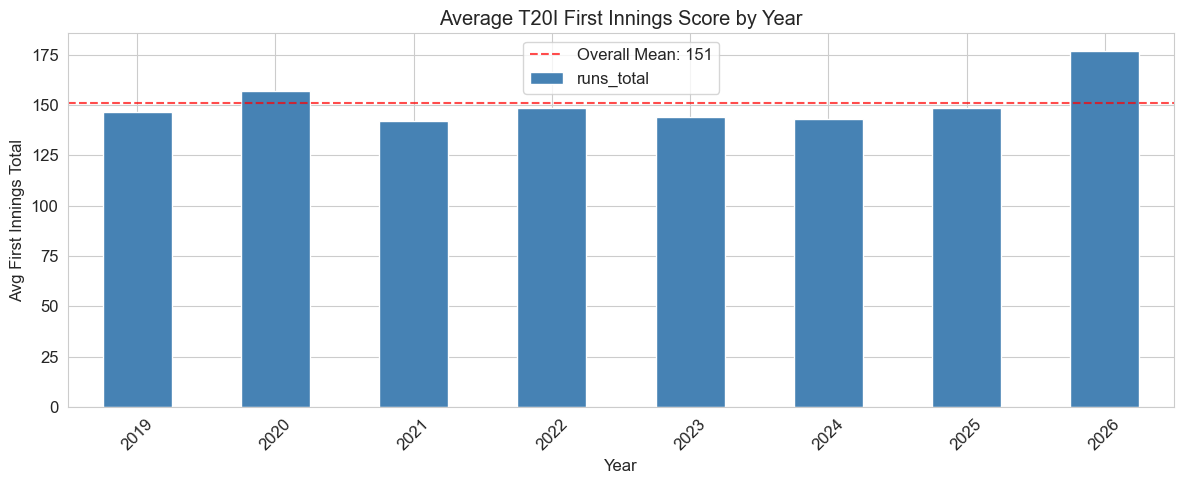

In [17]:
# Cell 16: Average first innings score by year
df["year"] = df["date"].dt.year

yearly_scores = (
    df[df["inning_no"] == 1]
    .groupby(["match_id", "year"])["runs_total"]
    .sum()
    .reset_index()
    .groupby("year")["runs_total"]
    .mean()
)

fig, ax = plt.subplots(figsize=(12, 5))
yearly_scores.plot(kind="bar", ax=ax, color="steelblue", edgecolor="white")
ax.set_xlabel("Year")
ax.set_ylabel("Avg First Innings Total")
ax.set_title("Average T20I First Innings Score by Year")
ax.axhline(yearly_scores.mean(), color="red", linestyle="--", alpha=0.7, label=f"Overall Mean: {yearly_scores.mean():.0f}")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

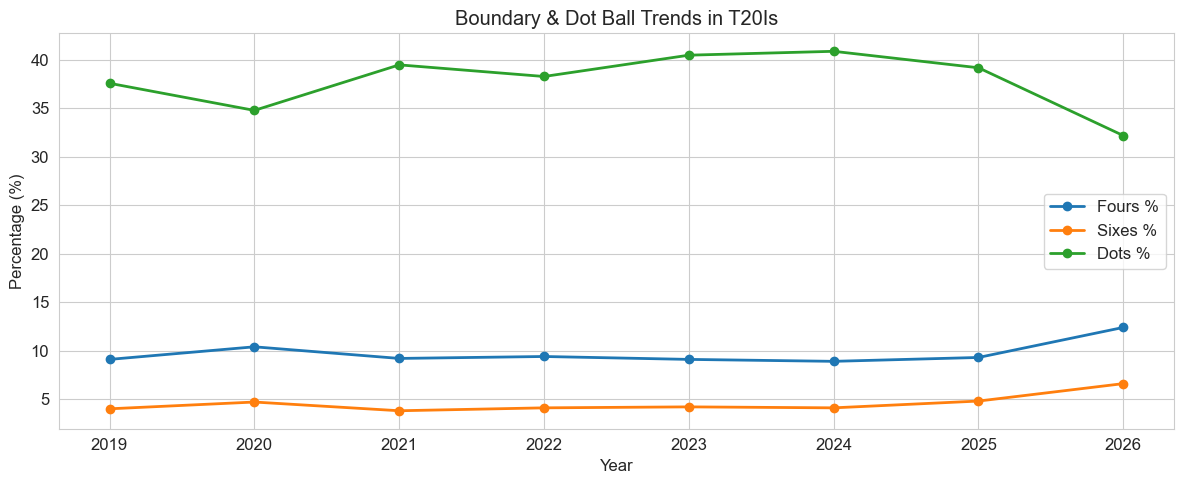

In [18]:
# Cell 17: Boundary rates over time
yearly_boundaries = (
    df.groupby("year")
    .agg(
        four_pct=("is_four", "mean"),
        six_pct=("is_six", "mean"),
        dot_pct=("is_dot", "mean"),
    )
    .mul(100)
    .round(1)
)

fig, ax = plt.subplots(figsize=(12, 5))
yearly_boundaries.plot(ax=ax, marker="o", linewidth=2)
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")
ax.set_title("Boundary & Dot Ball Trends in T20Is")
ax.legend(["Fours %", "Sixes %", "Dots %"])
plt.tight_layout()
plt.show()

## 8. Data Quality Summary
Final checks before we start feature engineering.

In [ ]:
# Cell 18: Summary statistics for the pipeline
print("=" * 60)
print("   CRICORACLE 2026 — DATA QUALITY REPORT")
print("=" * 60)
print(f"Total deliveries:    {len(df):>10,}")
print(f"Total matches:       {df['match_id'].nunique():>10,}")
print(f"Unique venues:       {df['venue'].nunique():>10,}")
print(f"Unique batters:      {df['batter'].nunique():>10,}")
print(f"Unique bowlers:      {df['bowler'].nunique():>10,}")
print(f"Date range:          {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Null values:         {df.isnull().sum().sum():>10,}")
print(f"Memory usage:        {df.memory_usage(deep=True).sum() / 1024**2:>9.1f} MB")
print(f"\nInnings split:")
print(df["inning_no"].value_counts().sort_index().to_string())
print(f"\nPhase split:")
print(df["phase"].value_counts().to_string())
print("=" * 60)
print("Data quality: READY FOR FEATURE ENGINEERING ✓")
print("=" * 60)

## ✅ Next Steps
Data looks good! Now move to the production codebase:

1. **Build player features:** `src/features/player.py` → run `pytest tests/test_features.py`
2. **Build venue features:** `src/features/venue.py`
3. **Run full pipeline:** `python scripts/train.py --pipeline`
4. **Train baseline model:** `python scripts/train.py --model win`